# genetic algorithms & enzyme engineering

Genetic algorithms are optimisation algorithms inspired by natural evolution that maximise or minimize a particular score function. 

They can be used in enzyme engineering to optimize a set of amino acids according to a desired function.

Like Darwinian evolution, the best performing 'genes' are selected from a large pool and repopulated by mating, which involves recombination and mutation of parent genes. Several iterations of the selection/mating process will yeild high scoring mutants.

In the case of enzyme engineering mutants can be selected based on how well they perform in a simulated task. Each iteration tends to yeild better performing mutants. 

Generally, the steps are:

```python
def generate_random_pop(n):
    ...
    return pop # random, len(pop) == n

def score(gene):
    ...
    return score

def select(pop, n):
    ...
    return n_best # n best by score()

def breed(pop, n):
    # mutate & crossover genes in the process
    ...
    return pop # mutants, len(pop) == n

def genetic_algorithm(pop, n_iterations):
    max_pop_size = len(pop) # not essential
    selection_size = 10 
        
    for i in range(num_iterations):
        pop = breed(pop, n = max_pop_size) # repopulate & mutate
        pop = select_best(pop, n = selection_size)
    return pop # return the best

starting_pop = generate_random_pop(n = 10) # population 10 random genes

good_mutants = genetic_algorithm(starting_pop, n_iterations = 10)
```

The selection process involves assessing the entire population according to some performance function. Evaluating this for an entire population can be time consuming if done one at a time. Since there is no interdependence between each performance evaluation, the population can be evaluated in parralel. 

Genetic algorithms tend to perform best with large populations. As a result, their effectiveness can be constrained by the available processing power.

## example - ```A``` content

well generate genes with dna characters & score based on the A content. here's a quick description of what we'll need to make:
- ```generate_random_pop_dna(``` - generate a random starting population, though starting populations can also be based on a reference sequence
- ```a_content(``` - an easy evaluation function for the example
- ```mutate_dna(``` - randomly choose a position & substitute with a random base
- ```cross(``` - recombination - cut two genes at a random position and splice the different fragments together. This creates two possible combinations, so one is randomly chosen
- ```select(``` -  return a fraction of the population that score best

In [1]:
import random

def generate_random_pop_dna(length, n):
    return [''.join(random.choices('ACTG', k = length)) for i in range(n)]

generate_random_pop_dna(20, 5)

['ACAACTATCCTAACCGCTTT',
 'ACATCCATAAATACGTCATT',
 'CAGCGATAAAGCAACTTGTA',
 'TCTTACCGCTGTTTACATGC',
 'CTCGTATGCCCTTGTGCTGT']

In [2]:
def a_content(gene):
    return sum([i == 'A' for i in gene]) / len(gene)

a_content('GCATGTCGTAGCTA')

0.21428571428571427

In [3]:
def mutate_dna(gene):
    gene = list(gene) # lists can be modified
    pos = random.randint(0, len(gene) - 1)
    gene[pos] = random.choice('ACTG')
    return ''.join(gene)

for i in range(5):
    print(mutate_dna('ACTG'))

ACTG
GCTG
ACTG
ACTC
ACTG


In [4]:
def cross(a, b):
    cut_point = random.randint(0, min(len(a), len(b)))
    ab = a[:cut_point] + b[cut_point:]
    ba = b[:cut_point] + a[cut_point:]
    return random.choice([ab,ba])

for i in range(5):
    print(cross('AAAAAA', 'CCCCCCC'))

AAAAACC
AAAAAAC
ACCCCCC
CCCCCC
ACCCCCC


In [5]:
from heapq import nlargest

def select(pop, score_fn, fraction):
    n = round(fraction * len(pop))
    return nlargest(n, pop, key = score_fn)

select(pop = generate_random_pop_dna(20, 10), 
       score_fn = a_content, 
       fraction = 0.4)

['AGCAATGGTTCCAGACGGAT',
 'AACATCTGACCCCCATTCAC',
 'GTCAACGAAAGGCATGTGCG',
 'TCTATAATATTGAGACTTTC']

In [6]:
pop = generate_random_pop_dna(20, 100)
pop_size = len(pop)

best = lambda p : max(map(a_content, p))

for iteration in range(10):
    pop = select(pop, a_content, 0.1)
    pop += random.choices(pop, k = pop_size - len(pop))
    pop = [mutate_dna(i) for i in pop]
    print(best(pop))

0.55
0.6
0.65
0.7
0.75
0.75
0.8
0.85
0.9
0.9


In [7]:
pop = generate_random_pop_dna(20, 100)
pop_size = len(pop)


for iteration in range(10):
    pop = select(pop, a_content, 0.1)
    pop = [cross(*random.choices(pop, k = 2)) for i in range(pop_size)]
    pop = [mutate_dna(i) for i in pop]
    print(best(pop))

0.65
0.8
0.85
0.9
0.95
0.95
0.95
1.0
1.0
1.0


In [8]:
def experiment(pop_size, n_iter, length, selection_fraction):
    pop = generate_random_pop_dna(length, pop_size)
    for i in range(n_iter):
        pop = select(pop, a_content, selection_fraction)
        pop = [cross(*random.choices(pop, k = 2)) for i in range(pop_size)]
        pop = [mutate_dna(i) for i in pop]
    return best(pop)
        

experiment(pop_size = 10, 
           n_iter = 3, 
           length = 40, 
           selection_fraction = 0.1)

0.4

## bigger is better
in large populations, good solutions are found faster

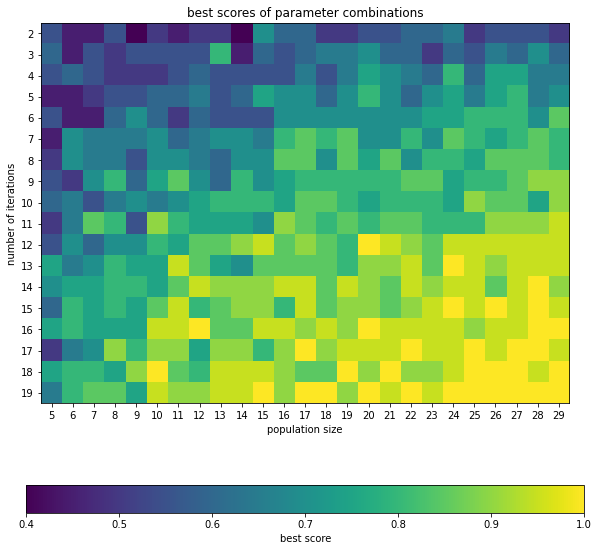

In [15]:
import numpy as np
import matplotlib.pyplot as plt


popsizes = range(5,30)
iteration_ranges = range(2,20)

arr = np.array([[experiment(pop_size = i,
                            n_iter =j, 
                            length = 20, 
                            selection_fraction = 0.2)\
          for i in popsizes] for j in iteration_ranges])

plt.figure(figsize = (10,10))
plt.imshow(arr)
plt.title('best scores of parameter combinations')
plt.xlabel('population size')
plt.xticks(range(len(popsizes)), popsizes)
plt.ylabel('number of iterations')
plt.yticks(range(len(iteration_ranges)), iteration_ranges)
plt.colorbar(label = 'best score', orientation = 'horizontal')
plt.show()

### parralelization
with a large population size & a time-consuming evaluation function, it makes sense to run the evalutions in parralel. the builtin python library ```multiprocessing``` is for managing parralel tasks. 

In [10]:
import time

def c_content_slow(gene):
    time.sleep(1)
    return sum([i == 'C' for i in gene]) / len(gene)

pop = generate_random_pop_dna(length = 20, n = 5)

for i in pop:
    print(i, c_content_slow(i))

ATCCGTGTTTCGGGTAGCTA 0.2
GAACTCCGATTTACGTGTAC 0.25
ATGCATCTTTATAGCTAACG 0.2
AAGCGACGGATCGGGCGAGA 0.2
GGGCAACGCAATAGATACCT 0.25


In [11]:
import multiprocessing

def c_content_parralel(pop):
    # with (aka resource manager) automatically closes the pool after it's done
    with multiprocessing.Pool(processes = len(pop)) as pool:
        results = pool.map(c_content_slow, pop)
    pool.join() # wait for processes to finish
    return results


c_content_parralel(pop)

[0.2, 0.25, 0.2, 0.2, 0.25]

In [12]:
%%timeit 
c_content_parralel(pop)

1.06 s ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
def select_parralel(pop, parralel_fn, frac = 0.1):
    scores_dict = dict(zip(pop, parralel_fn(pop)))
    return  nlargest(round(len(pop) * frac), 
                           scores_dict.keys(), 
                           key = lambda i : scores_dict[i])
    
pop = generate_random_pop_dna(length = 20, n = 100)
select_parralel(pop, c_content_parralel)

['CTTCCGATGCACGAAGCCCC',
 'CCCGCTTCGGTCTAGGCCTA',
 'CAAAGCCAGTACTCCATCCA',
 'GACGTCTGCAATCCCCGCTT',
 'GGAGCCGCAACGCCCATCTT',
 'ATTGCCCCCGAGCGTCTGGC',
 'CTCCACACAAAATTACCGAC',
 'GCCCCGGAGCTGTCCAGCGT',
 'TACAGGGCATTCCTCACGTC',
 'GAGAGAGCCGTGTCCCACTC']

In [14]:
pop = generate_random_pop_dna(length = 20, n = 100)
pop_size = len(pop)

c_content_fast = lambda gene : sum([i == 'C' for i in gene]) / len(gene)
best_c_content = lambda pop : max([c_content_fast(i) for i in pop])

for iteration in range(10):
    pop = select_parralel(pop, c_content_parralel, frac = 0.1)
    pop = [cross(*random.choices(pop, k = 2)) for i in range(pop_size)]
    pop = [mutate_dna(i) for i in pop]
    print(best_c_content(pop))

0.65
0.75
0.8
0.85
0.9
0.95
0.95
1.0
1.0
1.0


# genetic algorithms with ```enz```

```python
import enz
import random
import heapq
import multiprocessing

from my_stuff import bm3_sequence, custom_docking_score

AAS = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

TARGET_SITES = [49, 51, 75, 82, 87, 181, 188, 263, 330]

def mutate(gene):
    ...

def cross(a, b):
    ...

def evaluate(gene):
    mutation_dictionary = dict(zip(TARGET_SITES, gene))
    p = enz.protein('1bu7.pdb',
                    seq = bm3_sequence, # my residue numbering system
                    cofactors = ['HEM']) # keep the heme
    for pos in mutation_dictionary:
        aa = mutation_dictionary[pos]
        p.mutate(pos, aa)
    p.refold()
    
    docking_results = p.dock('CCS(=O)(=O)C1=C(N2C=CC=CC2=N1)S(=O)(=O)NC(=O)NC3=NC(=CC(=N3)OC)OC',
                             target_sites = TARGET_SITES)
    return custom_docking_score(p, docking_results) # based geometry & affinity

def parralel_evaluate(pop):
    with multiprocessing.Pool(len(pop)) as pool:
        results = pool.map(evaluate, pop)
    pool.join()
    return results

def select_parralel(pop, parralel_fn, frac = 0.1):
    scores_dict = dict(zip(pop, parralel_fn(pop)))
    return  nlargest(round(len(pop) * frac), 
                           scores_dict.keys(), 
                           key = lambda i : scores_dict[i])    

def main():
    pop_size = 20
    pop = [mutate('TYLFVLLIA') for i in range(pop_size)]
    for i in range(10):
        pop = select_parralel(pop, parralel_evaluate, frac = 0.3)
        pop = [cross(*random.choices(pop, k = 2)) for i in range(pop_size)]
        pop = [mutate(i) for i in pop]
    ...
    # save best mutant etc
    
main()
```